## 日志
#### 2017.08.05
- 接下来,怎么把o dtype 转换成 uint64 dtype? A: 在插入in和out的长宽时发现应该是直接可以自动识别的.
* 建立特征, 把每个link的in 和out 对应长宽也插入columns A: 完成
* 把in和out对应的travel_time也最好加进来,但是要看好t0起码接近...很可能不行.
* 研究一下t0的规律(下图是在别的notebook里研究的全部数据的t0的规律)
![](t0_dist_intvl.png)
- 下图是每个link_ID包含时间点数据的数量分布![](t0_dist.png) 

* 看一下travel_time和length,width,t0的关系 
- 怎么把datetime64数据变成特征? 做成timedelta然后成为标记在年,月,周,日中位置的数据? 待讨论请教.
- 网上找的对时间数据的特征化:离散化，离散化成0-1向量(比如周级别为7维向量);加入是是否是特殊日期的向量(一维，0 or 1), 所以我先把时间数据离散成年,月,日,周,时,分. 或者是utc时间(适用聚类). 或者还可以分桶. 
- 现有的特征可以套进去GBDT试一下, 但是没有把时间数据作为特征的手段的话, 也不能预测啊

#### 2017.08.06
- 继续把datetime的dir看完

## 代码实现

In [1]:
import pandas as pd
import numpy as np

## 导入数据

In [96]:
s = pd.read_csv('gy_contest_link_traveltime_training_data.txt',nrows=1000,sep=';')
s.to_csv('gy_contest_link_traveltime_training_sample.csv',sep=';')

In [98]:
s = pd.read_csv('gy_contest_link_traveltime_training_sample.csv',sep=';',index_col=0)
s.head()

,link_ID,date,time_interval,travel_time
0,9377906285566510514,2016-05-21,"[2016-05-21 23:20:00,2016-05-21 23:22:00)",17.6
1,3377906288228510514,2016-05-21,"[2016-05-21 18:46:00,2016-05-21 18:48:00)",3.5
2,3377906284395510514,2016-05-21,"[2016-05-21 07:06:00,2016-05-21 07:08:00)",10.0
3,4377906284959500514,2016-05-21,"[2016-05-21 14:34:00,2016-05-21 14:36:00)",3.5
4,9377906282776510514,2016-05-21,"[2016-05-21 05:04:00,2016-05-21 05:06:00)",1.5


In [2]:
sample = pd.read_csv('gy_contest_link_traveltime_training_data.txt',nrows=1000,sep=';') # 车流量数据

In [3]:
link_info = pd.read_csv('gy_contest_link_info.txt',sep=';') # 路段id,length,width数据

In [4]:
link_top = pd.read_csv('gy_contest_link_top.txt',sep=';')# 路段拓扑关系数据

## 对sample进行预处理

In [5]:
sample['id'] = round(sample['link_ID']//(10**6)%(10**4))

In [6]:
tm_itvl=sample['time_interval'].str.replace('[','').str.replace(')','').str.split(',')
sample['t0'] = tm_itvl.apply(lambda x: x[0])
sample['t1'] = tm_itvl.apply(lambda x: x[1])

In [7]:
sample['date'] = pd.to_datetime(sample['date'])
sample['t0'] = pd.to_datetime(sample['t0'])
sample['t1'] = pd.to_datetime(sample['t1'])

In [8]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
link_ID          1000 non-null uint64
date             1000 non-null datetime64[ns]
time_interval    1000 non-null object
travel_time      1000 non-null float64
id               1000 non-null uint64
t0               1000 non-null datetime64[ns]
t1               1000 non-null datetime64[ns]
dtypes: datetime64[ns](3), float64(1), object(1), uint64(2)
memory usage: 54.8+ KB


In [9]:
sample.head()

,link_ID,date,time_interval,travel_time,id,t0,t1
0,9377906285566510514,2016-05-21,"[2016-05-21 23:20:00,2016-05-21 23:22:00)",17.6,5566,2016-05-21 23:20:00,2016-05-21 23:22:00
1,3377906288228510514,2016-05-21,"[2016-05-21 18:46:00,2016-05-21 18:48:00)",3.5,8228,2016-05-21 18:46:00,2016-05-21 18:48:00
2,3377906284395510514,2016-05-21,"[2016-05-21 07:06:00,2016-05-21 07:08:00)",10.0,4395,2016-05-21 07:06:00,2016-05-21 07:08:00
3,4377906284959500514,2016-05-21,"[2016-05-21 14:34:00,2016-05-21 14:36:00)",3.5,4959,2016-05-21 14:34:00,2016-05-21 14:36:00
4,9377906282776510514,2016-05-21,"[2016-05-21 05:04:00,2016-05-21 05:06:00)",1.5,2776,2016-05-21 05:04:00,2016-05-21 05:06:00


## 对link_top进行预处理

In [10]:
link_top[['in0','in1','in2','in3']]=link_top['in_links'].str.split('#',expand=True) 
link_top[['out0','out1','out2','out3']]=link_top['out_links'].str.split('#',expand=True) 

In [11]:
link_top.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 11 columns):
link_ID      132 non-null uint64
in_links     126 non-null object
out_links    125 non-null object
in0          126 non-null object
in1          28 non-null object
in2          9 non-null object
in3          4 non-null object
out0         125 non-null object
out1         29 non-null object
out2         9 non-null object
out3         4 non-null object
dtypes: object(10), uint64(1)
memory usage: 11.4+ KB


In [12]:
link_top.head()

,link_ID,in_links,out_links,in0,in1,in2,in3,out0,out1,out2,out3
0,4377906289869500514,4377906285525800514,4377906281969500514,4377906285525800514,None,None,None,4377906281969500514,None,None,None
1,4377906284594800514,4377906284514600514,4377906285594800514,4377906284514600514,None,None,None,4377906285594800514,None,None,None
2,4377906289425800514,NaN,4377906284653600514,NaN,None,None,None,4377906284653600514,None,None,None
3,4377906284525800514,4377906281234600514,4377906280334600514,4377906281234600514,None,None,None,4377906280334600514,None,None,None
4,4377906284422600514,3377906289434510514#4377906287959500514,4377906283422600514,3377906289434510514,4377906287959500514,None,None,4377906283422600514,None,None,None


## 对link_info进行预处理

In [13]:
link_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 4 columns):
link_ID       132 non-null uint64
length        132 non-null int64
width         132 non-null int64
link_class    132 non-null int64
dtypes: int64(3), uint64(1)
memory usage: 4.2 KB


In [14]:
link_info.head()

,link_ID,length,width,link_class
0,4377906289869500514,57,3,1
1,4377906284594800514,247,9,1
2,4377906289425800514,194,3,1
3,4377906284525800514,839,3,1
4,4377906284422600514,55,12,1


## 对数据进行合并

In [15]:
alldata= sample[['link_ID','date','t0','t1','travel_time']]

In [16]:
alldata = pd.merge(alldata, link_info[['link_ID','length','width']], how='left', on='link_ID')

In [17]:
alldata = pd.merge(alldata, link_top[['link_ID','in0','in1','in2','in3','out0','out1','out2','out3']], how='left',on='link_ID')

In [42]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 31 columns):
link_ID        1000 non-null uint64
date           1000 non-null datetime64[ns]
t0             1000 non-null datetime64[ns]
t1             1000 non-null datetime64[ns]
travel_time    1000 non-null float64
length         1000 non-null int64
width          1000 non-null int64
in0            962 non-null object
in1            238 non-null object
in2            79 non-null object
in3            33 non-null object
out0           929 non-null object
out1           222 non-null object
out2           66 non-null object
out3           32 non-null object
in0_len        962 non-null float64
in1_len        238 non-null float64
in2_len        79 non-null float64
in3_len        33 non-null float64
out0_len       929 non-null float64
out1_len       222 non-null float64
out2_len       66 non-null float64
out3_len       32 non-null float64
in0_wid        962 non-null float64
in1_wid        238 non-

In [41]:
alldata.head()

,link_ID,date,t0,t1,travel_time,length,width,in0,in1,in2,...,out2_len,out3_len,in0_wid,in1_wid,in2_wid,in3_wid,out0_wid,out1_wid,out2_wid,out3_wid
0,9377906285566510514,2016-05-21,2016-05-21 23:20:00,2016-05-21 23:22:00,17.6,143,9,4377906283759500514,9377906286566510514,None,...,NaN,NaN,9.0,9.0,NaN,NaN,9.0,NaN,NaN,NaN
1,3377906288228510514,2016-05-21,2016-05-21 18:46:00,2016-05-21 18:48:00,3.5,26,12,3377906289228510514,None,None,...,NaN,NaN,12.0,NaN,NaN,NaN,12.0,NaN,NaN,NaN
2,3377906284395510514,2016-05-21,2016-05-21 07:06:00,2016-05-21 07:08:00,10.0,43,12,3377906286918510514,3377906287674510514,4377906287243600514,...,NaN,NaN,12.0,12.0,12.0,9.0,12.0,NaN,NaN,NaN
3,4377906284959500514,2016-05-21,2016-05-21 14:34:00,2016-05-21 14:36:00,3.5,22,9,4377906282969500514,4377906285141600514,4377906289141600514,...,NaN,NaN,12.0,12.0,15.0,NaN,9.0,NaN,NaN,NaN
4,9377906282776510514,2016-05-21,2016-05-21 05:04:00,2016-05-21 05:06:00,1.5,9,9,9377906283776510514,None,None,...,NaN,NaN,9.0,NaN,NaN,NaN,9.0,NaN,NaN,NaN


In [20]:
alldata['t0'].value_counts()

2016-05-21 07:16:00    6
2016-05-21 19:00:00    5
2016-05-21 03:58:00    5
2016-05-21 16:42:00    5
2016-05-21 15:24:00    5
2016-05-21 03:56:00    5
2016-05-21 23:08:00    5
2016-05-21 18:22:00    5
2016-05-21 10:48:00    5
2016-05-21 14:40:00    4
2016-05-21 22:52:00    4
2016-05-21 15:38:00    4
2016-05-21 09:30:00    4
2016-05-21 16:50:00    4
2016-05-21 11:58:00    4
2016-05-21 19:26:00    4
2016-05-21 02:40:00    4
2016-05-21 19:30:00    4
2016-05-21 00:02:00    4
2016-05-21 00:48:00    4
2016-05-21 10:06:00    4
2016-05-21 15:00:00    4
2016-05-21 17:30:00    4
2016-05-21 10:16:00    4
2016-05-21 10:18:00    4
2016-05-21 22:32:00    4
2016-05-21 12:46:00    4
2016-05-21 17:40:00    4
2016-05-21 13:12:00    4
2016-05-21 17:46:00    4
                      ..
2016-05-21 07:04:00    1
2016-05-21 13:08:00    1
2016-05-21 10:42:00    1
2016-05-21 02:10:00    1
2016-05-21 00:56:00    1
2016-05-21 21:42:00    1
2016-05-21 08:16:00    1
2016-05-21 16:48:00    1
2016-05-21 09:28:00    1


## 把每个link的in 和out 对应长宽也插入columns,

In [36]:
def in_length(x):
    try:
        return link_info.query("link_ID=='%s'" % x)['length'].iloc[0]
    except:
        return None
alldata['in0_len']=alldata['in0'].apply(in_length)
alldata['in1_len']=alldata['in1'].apply(in_length)
alldata['in2_len']=alldata['in2'].apply(in_length)
alldata['in3_len']=alldata['in3'].apply(in_length)

In [38]:
alldata['out0_len']=alldata['out0'].apply(in_length)
alldata['out1_len']=alldata['out1'].apply(in_length)
alldata['out2_len']=alldata['out2'].apply(in_length)
alldata['out3_len']=alldata['out3'].apply(in_length)

In [39]:
def in_width(x):
    try:
        return link_info.query("link_ID=='%s'" % x)['width'].iloc[0]
    except:
        return None
alldata['in0_wid']=alldata['in0'].apply(in_width)
alldata['in1_wid']=alldata['in1'].apply(in_width)
alldata['in2_wid']=alldata['in2'].apply(in_width)
alldata['in3_wid']=alldata['in3'].apply(in_width)

In [40]:
alldata['out0_wid']=alldata['out0'].apply(in_width)
alldata['out1_wid']=alldata['out1'].apply(in_width)
alldata['out2_wid']=alldata['out2'].apply(in_width)
alldata['out3_wid']=alldata['out3'].apply(in_width)

## 研究一下t0的规律

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

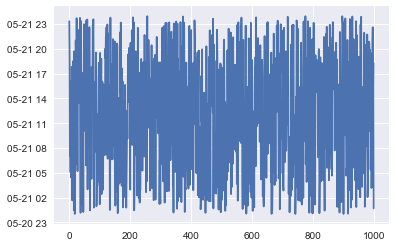

In [49]:
plt.plot(alldata['t0'])

TypeError: invalid type promotion

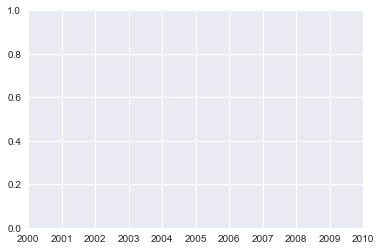

In [50]:
plt.hist(alldata['t0'])

In [45]:
sns.factorplot(alldata['t0'])

TypeError: object of type 'NoneType' has no len()

## 每个的link_ID的t0的情况(有多少条)

In [53]:
alldata[['link_ID','t0']].groupby('link_ID').count()

,t0
link_ID,
3377906280028510514,9
3377906280395510514,4
3377906281518510514,15
3377906281774510514,5
3377906282328510514,9
3377906282418510514,11
3377906283328510514,13
3377906284028510514,5
3377906284395510514,11


## 看一下travel_time和length,width,t0的关系

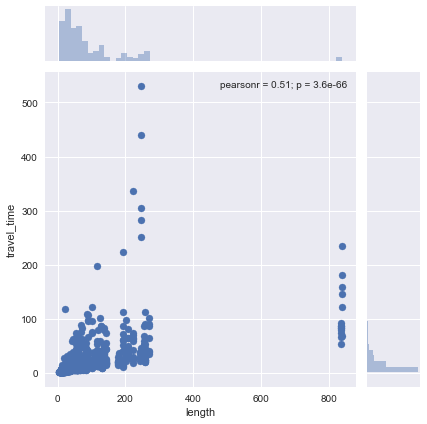

In [56]:
sns.jointplot(alldata['length'],alldata['travel_time'],)

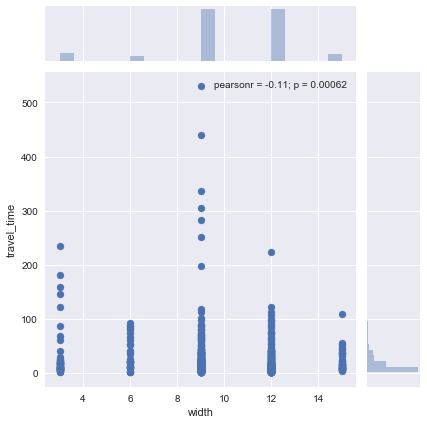

In [55]:
sns.jointplot('width','travel_time',data=alldata)

## 分割时间数据

In [58]:
dir(alldata['t0'][0])

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rsub__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__weakref__',
 '_date_repr',
 '_get_field',
 '_get_start_end_field',
 '_has_time_component',
 '_repr_base',
 '_round',
 '_short_repr',
 '_time_repr',
 'asm8',
 'astimezone',
 'ceil',
 'combine',
 'ctime',
 'date',
 'day',
 'dayofweek',
 'dayofyear',
 'days_in_month',
 'daysinmonth',
 'dst',
 'floor',
 'fold',
 'freq',
 'freqstr',
 'fromordinal',
 'fromtimestamp',
 'hour',
 'is_leap_year',
 'is_month_end',
 'is_month_start',
 'is_quarter_end',
 'is_quarter_start',
 'is_year_end',
 'is_year_start',
 'isocalendar',
 'isoformat',
 'isoweekday',
 'max',
 'm

In [59]:
a = alldata['t0'][0]

In [60]:
a.year

2016

In [61]:
a.month

5

In [62]:
a.week

20

In [63]:
a.day

21

In [78]:
a.hour

23

In [79]:
a.minute

20

In [80]:
a.second

0

In [70]:
a.weekday()

5

In [65]:
a.weekofyear

20

In [67]:
a.utcnow()

Timestamp('2017-08-05 16:19:26.251041+0000', tz='UTC')

In [71]:
a.value

1463872800000000000

In [73]:
a.today()

Timestamp('2017-08-06 00:20:09.134832')

In [75]:
a.asm8

numpy.datetime64('2016-05-21T23:20:00.000000000')

In [77]:
a.astimezone

<bound method Timestamp.tz_convert of Timestamp('2016-05-21 23:20:00')>

In [83]:
a.ceil

<bound method Timestamp.ceil of Timestamp('2016-05-21 23:20:00')>

In [86]:
a.combine

<bound method Timestamp.combine of <class 'pandas._libs.tslib.Timestamp'>>

In [90]:
a.ctime()

'Sat May 21 23:20:00 2016'

In [93]:
dir(a.date())

['__add__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rsub__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 'ctime',
 'day',
 'fromordinal',
 'fromtimestamp',
 'isocalendar',
 'isoformat',
 'isoweekday',
 'max',
 'min',
 'month',
 'replace',
 'resolution',
 'strftime',
 'timetuple',
 'today',
 'toordinal',
 'weekday',
 'year']